In [1]:
pip install lightgbm catboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
import time
import shap

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [93]:
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [6]:
numerical_features = train_data.select_dtypes(include=['int64', 'float64']).columns
min_values = train_data[numerical_features].min()
max_values = train_data[numerical_features].max()
median_values = train_data[numerical_features].median()

# Вывод результатов
print("\nСтатистики (Min, Max, Median):")
for feature in numerical_features:
    print(f"{feature}: Min = {min_values[feature]}, Max = {max_values[feature]}, Median = {median_values[feature]}")



Статистики (Min, Max, Median):
Id: Min = 1.0, Max = 1460.0, Median = 730.5
MSSubClass: Min = 20.0, Max = 190.0, Median = 50.0
LotFrontage: Min = 21.0, Max = 313.0, Median = 69.0
LotArea: Min = 1300.0, Max = 215245.0, Median = 9478.5
OverallQual: Min = 1.0, Max = 10.0, Median = 6.0
OverallCond: Min = 1.0, Max = 9.0, Median = 5.0
YearBuilt: Min = 1872.0, Max = 2010.0, Median = 1973.0
YearRemodAdd: Min = 1950.0, Max = 2010.0, Median = 1994.0
MasVnrArea: Min = 0.0, Max = 1600.0, Median = 0.0
BsmtFinSF1: Min = 0.0, Max = 5644.0, Median = 383.5
BsmtFinSF2: Min = 0.0, Max = 1474.0, Median = 0.0
BsmtUnfSF: Min = 0.0, Max = 2336.0, Median = 477.5
TotalBsmtSF: Min = 0.0, Max = 6110.0, Median = 991.5
1stFlrSF: Min = 334.0, Max = 4692.0, Median = 1087.0
2ndFlrSF: Min = 0.0, Max = 2065.0, Median = 0.0
LowQualFinSF: Min = 0.0, Max = 572.0, Median = 0.0
GrLivArea: Min = 334.0, Max = 5642.0, Median = 1464.0
BsmtFullBath: Min = 0.0, Max = 3.0, Median = 0.0
BsmtHalfBath: Min = 0.0, Max = 2.0, Median = 

In [7]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
train_data.shape

(1460, 81)

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [10]:
# Вывожу количество уникальных значений в каждом столбце
train_data.nunique().sort_values()

CentralAir         2
Utilities          2
Street             2
Alley              2
BsmtHalfBath       3
                ... 
1stFlrSF         753
BsmtUnfSF        780
GrLivArea        861
LotArea         1073
Id              1460
Length: 81, dtype: int64

In [11]:
print(train_data.describe())

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

In [12]:
# Проверяю на дубликаты
train_data[train_data.duplicated(keep = False)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [13]:
# Проверка пропусков
missing_values = train_data.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


In [14]:
# Удаление первых четырёх столбцов с наибольшим количеством пропусков
columns_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
train_data = train_data.drop(columns=columns_to_drop)

# Проверка после удаления
print(train_data.isnull().sum().sort_values(ascending=False))

MasVnrType     872
FireplaceQu    690
LotFrontage    259
GarageCond      81
GarageYrBlt     81
              ... 
BsmtUnfSF        0
TotalBsmtSF      0
MSSubClass       0
HeatingQC        0
SalePrice        0
Length: 77, dtype: int64


In [15]:
# Разделение признаков на числовые и категориальные
numerical_features = train_data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_data.select_dtypes(include=['object']).columns

In [16]:
# Заполнение пропусков для числовых данных
num_imputer = SimpleImputer(strategy='median')
train_data[numerical_features] = num_imputer.fit_transform(train_data[numerical_features])

In [17]:
# Заполнение пропусков для категориальных данных
cat_imputer = SimpleImputer(strategy='most_frequent')
train_data[categorical_features] = cat_imputer.fit_transform(train_data[categorical_features])

In [18]:
# Проверка пропусков
missing_values = train_data.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

Series([], dtype: int64)


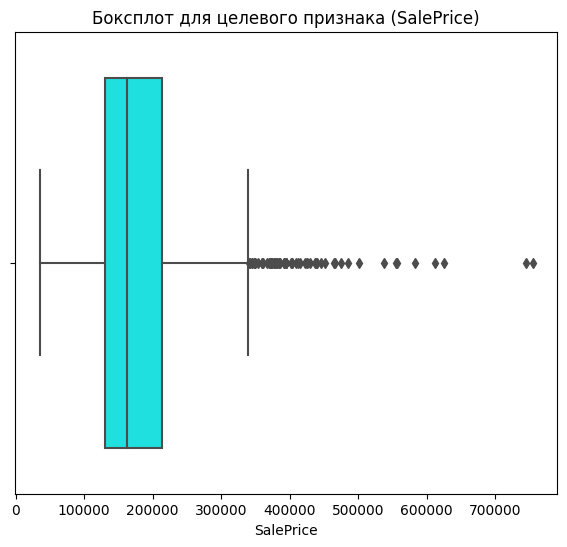

In [19]:
# Визуализация выбросов с помощью боксплота
plt.figure(figsize=(7, 6))
sns.boxplot(x=train_data['SalePrice'], color='aqua')
plt.title("Боксплот для целевого признака (SalePrice)")
plt.show()

In [20]:
# Определение порога выбросов
Q1 = train_data['SalePrice'].quantile(0.25)
Q3 = train_data['SalePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [21]:
outliers = train_data[(train_data['SalePrice'] < lower_bound) | (train_data['SalePrice'] > upper_bound)]
print(f"Количество выбросов: {len(outliers)}")

Количество выбросов: 61


In [22]:
'''# Заменяем на нижнюю или верхнюю границу
train_data['SalePrice'] = train_data['SalePrice'].apply(
    lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
)

print(f"Данные после замены выбросов: {train_data.shape}")'''

'# Заменяем на нижнюю или верхнюю границу\ntrain_data[\'SalePrice\'] = train_data[\'SalePrice\'].apply(\n    lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x\n)\n\nprint(f"Данные после замены выбросов: {train_data.shape}")'

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


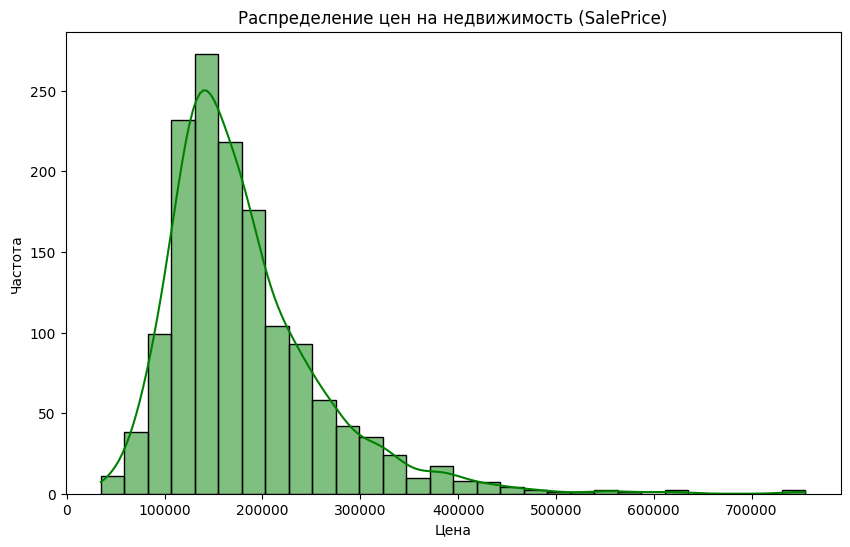

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], kde=True, bins=30, color='green')
plt.title("Распределение цен на недвижимость (SalePrice)")
plt.xlabel("Цена")
plt.ylabel("Частота")
plt.show()

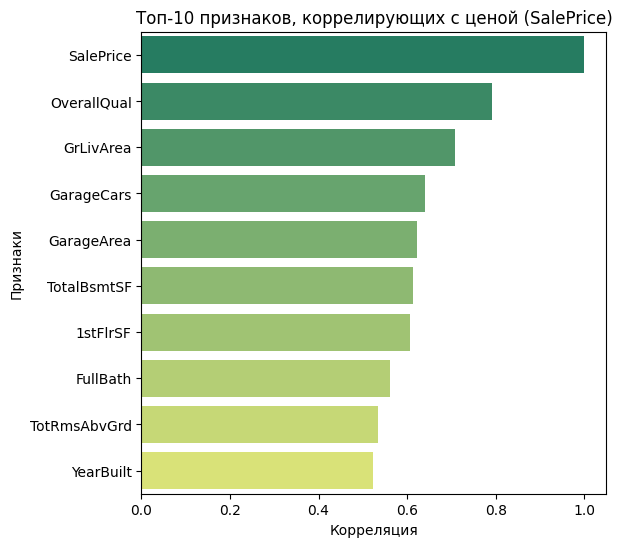

In [24]:
# Выбираем только числовые данные
numerical_data = train_data.select_dtypes(include=['int64', 'float64'])

# Вычисляем корреляционную матрицу
corr_matrix = numerical_data.corr()

# Топ-10 признаков, коррелирующих с SalePrice
top_corr_features = corr_matrix['SalePrice'].sort_values(ascending=False).head(10)

plt.figure(figsize=(6, 6))
sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette="summer")
plt.title("Топ-10 признаков, коррелирующих с ценой (SalePrice)")
plt.xlabel("Корреляция")
plt.ylabel("Признаки")
plt.show()

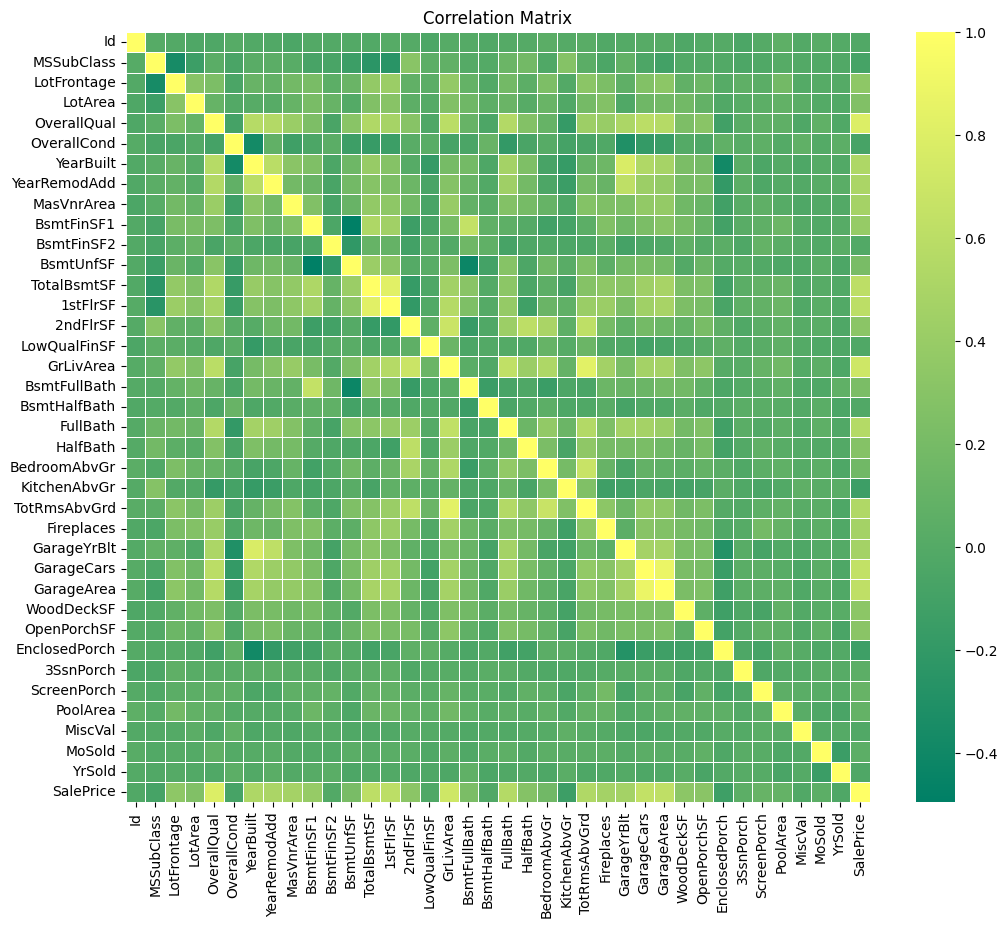

In [25]:
# Оставляем только числовые столбцы
numeric_data = train_data.select_dtypes(include=["float64", "int64"])

# Рассчитываем корреляцию
correlation_matrix = numeric_data.corr()

# Построение тепловой карты
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="summer", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [26]:
# Выбираем только числовые данные
numerical_data = train_data.select_dtypes(include=['int64', 'float64'])

# Вычисляем корреляцию с SalePrice
corr_matrix = numerical_data.corr()

# Топ-16 признаков, коррелирующих с SalePrice
top_16_features = corr_matrix['SalePrice'].sort_values(ascending=False).head(17).index[1:]  # Убираем SalePrice
print("Топ-16 признаков:", top_16_features)

Топ-16 признаков: Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'Fireplaces', 'GarageYrBlt', 'BsmtFinSF1', 'LotFrontage',
       'WoodDeckSF'],
      dtype='object')


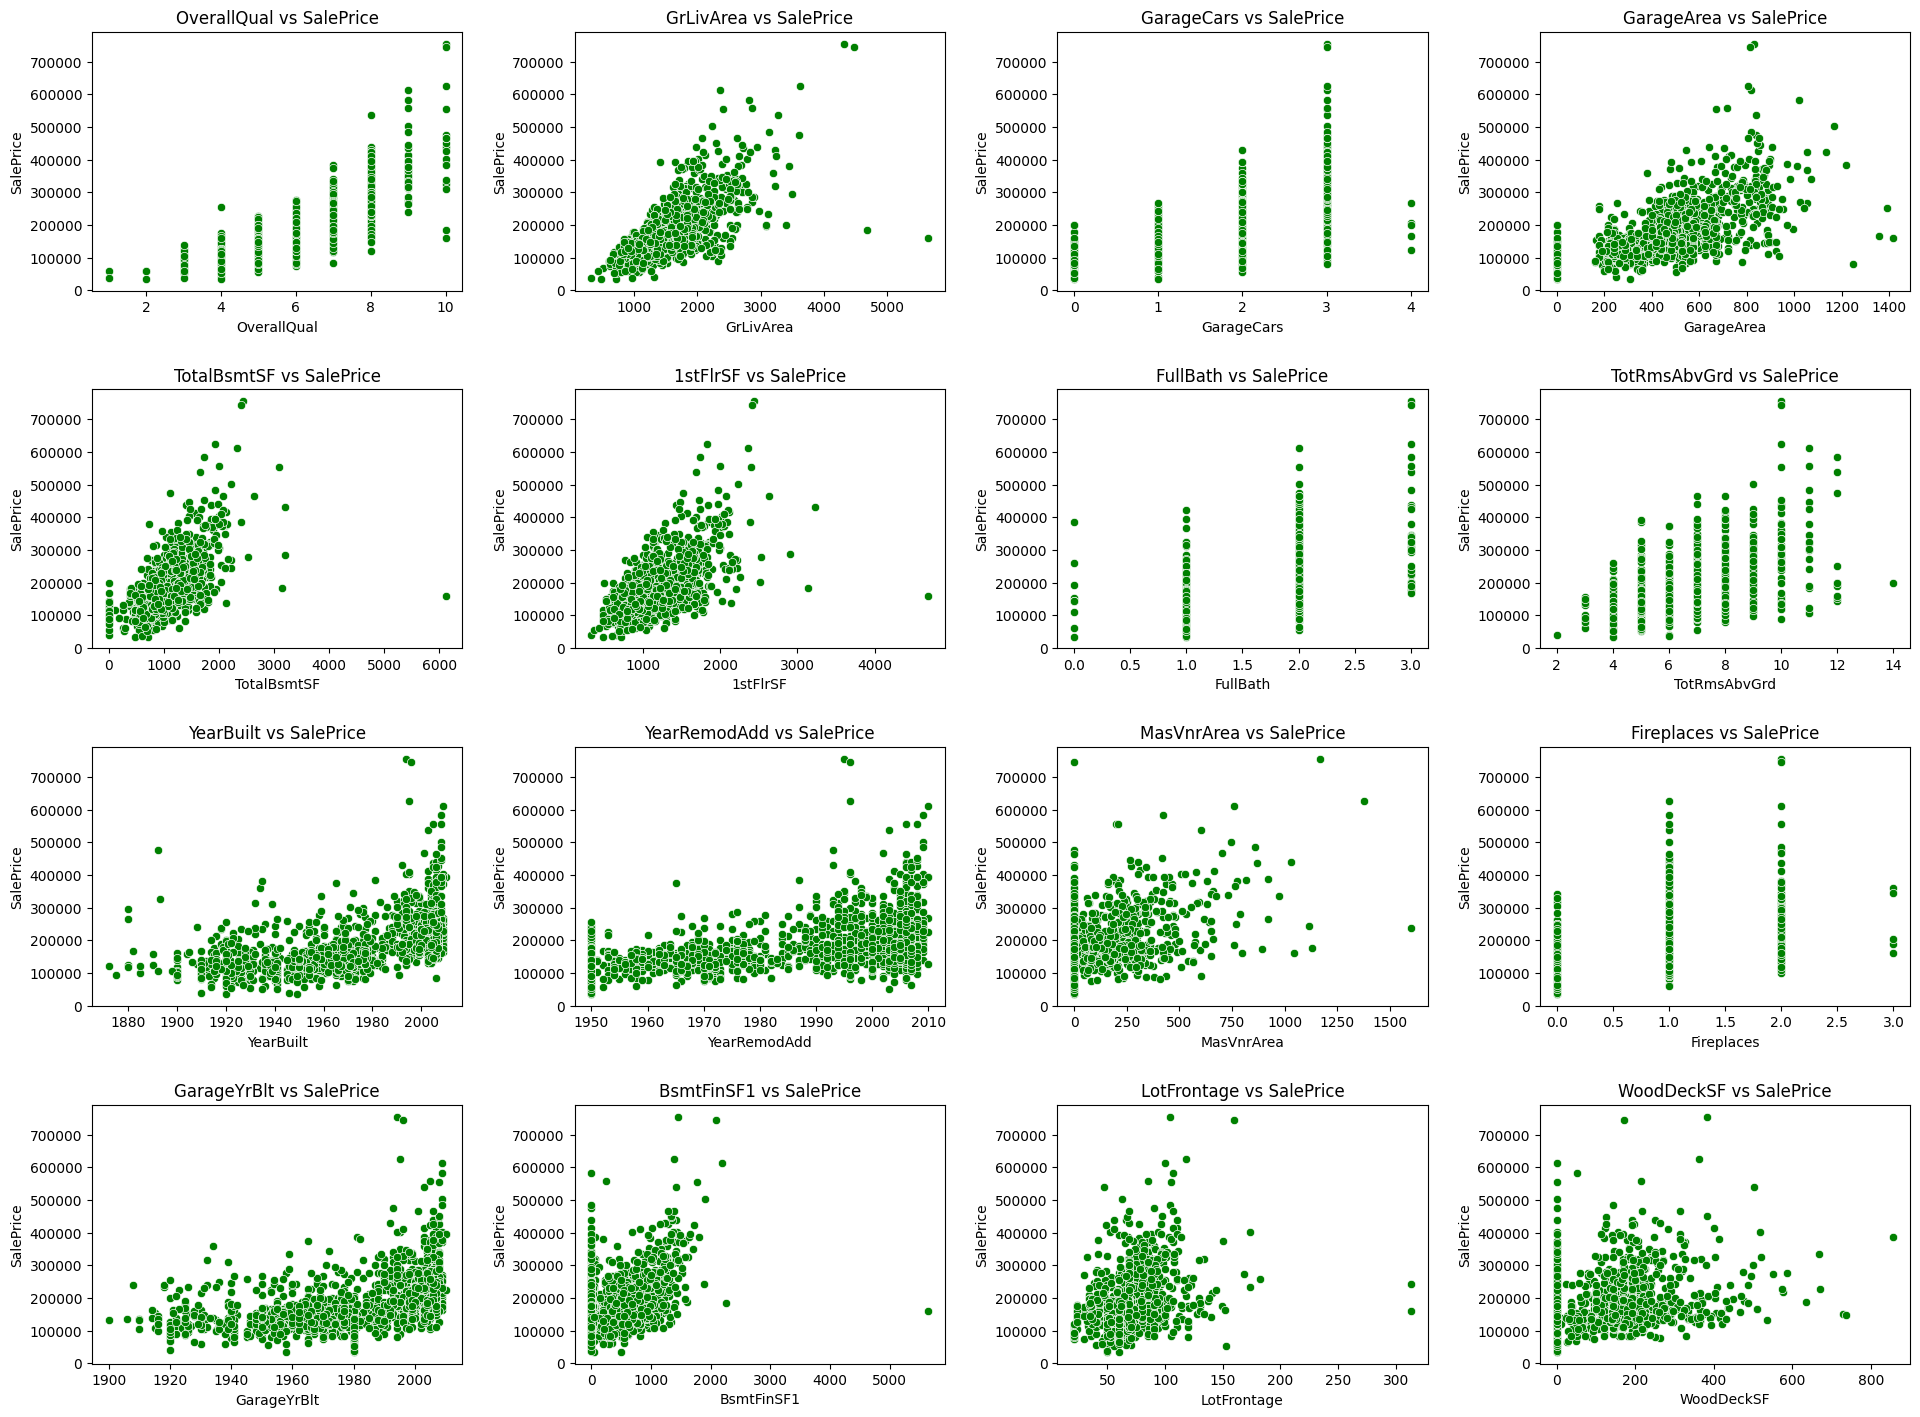

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Размер сетки для графиков
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
fig.tight_layout(pad=5.0)

# Создаем графики для каждого признака
for i, feature in enumerate(top_16_features):
    row, col = divmod(i, 4)
    sns.scatterplot(data=train_data, x=feature, y='SalePrice', ax=axes[row, col], color='green')
    axes[row, col].set_title(f"{feature} vs SalePrice")
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel("SalePrice")

plt.show()

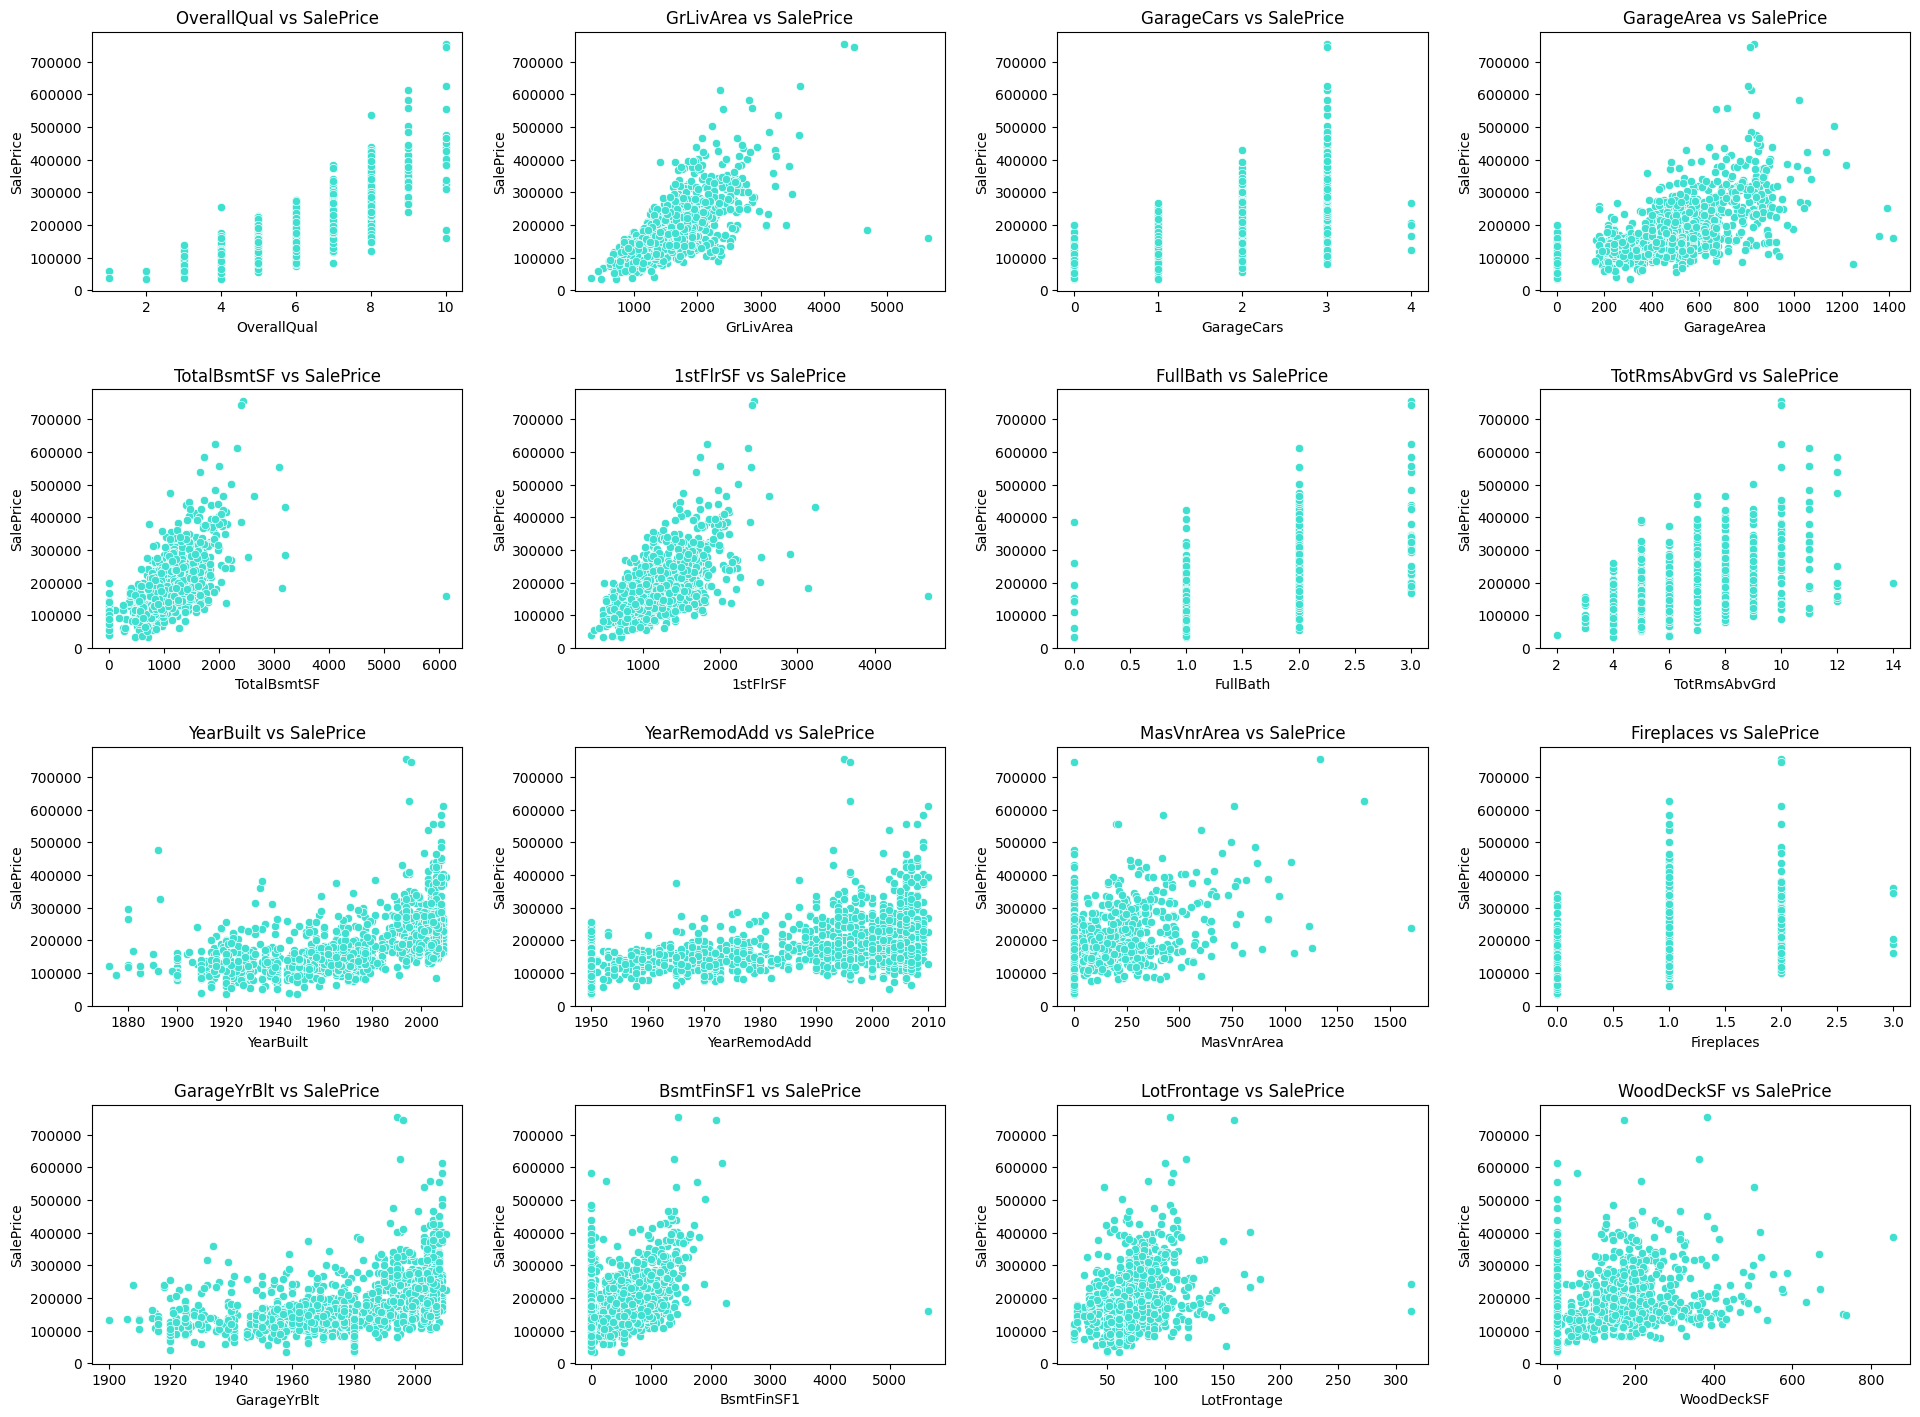

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Размер сетки для графиков
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
fig.tight_layout(pad=5.0)

# Создаем графики для каждого признака
for i, feature in enumerate(top_16_features):
    row, col = divmod(i, 4)
    sns.scatterplot(data=numerical_data, x=feature, y='SalePrice', ax=axes[row, col], color='turquoise')
    axes[row, col].set_title(f"{feature} vs SalePrice")
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel("SalePrice")

plt.show()

In [29]:
# Выявление коррелированных признаков
print("\nВыявление сильно коррелированных признаков:")
corr_matrix = numerical_data.corr()
high_corr_pairs = [
    (column, idx, corr_matrix[column][idx])
    for column in corr_matrix.columns
    for idx in corr_matrix.index
    if 0.8 <= abs(corr_matrix[column][idx]) < 1.0
]
for col1, col2, corr in high_corr_pairs:
    print(f"{col1} и {col2} имеют корреляцию: {corr:.2f}")



Выявление сильно коррелированных признаков:
TotalBsmtSF и 1stFlrSF имеют корреляцию: 0.82
1stFlrSF и TotalBsmtSF имеют корреляцию: 0.82
GrLivArea и TotRmsAbvGrd имеют корреляцию: 0.83
TotRmsAbvGrd и GrLivArea имеют корреляцию: 0.83
GarageCars и GarageArea имеют корреляцию: 0.88
GarageArea и GarageCars имеют корреляцию: 0.88


In [30]:
# Столбцы для удаления
columns_to_drop = ['GarageYrBlt', 'TotRmsAbvGrd', 'GarageArea', 'TotalBsmtSF']

# Удаление столбцов из набора данных
train_data = train_data.drop(columns=columns_to_drop)

In [31]:
# Разделение данных
X = train_data.drop(['SalePrice', 'Id'], axis=1)
y = train_data['SalePrice']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Преобразование данных
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [35]:
# Преобразование данных
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [36]:
# Определяем числовые столбцы
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns

# Функция для замены выбросов на граничные значения
def replace_outliers_with_boundaries(data, cols):
    for col in cols:
        Q1 = data[col].quantile(0.25)  # Первый квартиль
        Q3 = data[col].quantile(0.75)  # Третий квартиль
        IQR = Q3 - Q1  # Межквартильный размах

        lower_bound = Q1 - 1.5 * IQR  # Нижняя граница
        upper_bound = Q3 + 1.5 * IQR  # Верхняя граница

        # Заменяем выбросы на граничные значения
        data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
        data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])

# Применяем функцию к тренировочному набору
replace_outliers_with_boundaries(train_data, numerical_cols)

# Проверим результат для одного из столбцов (например, 'SalePrice')
print(train_data['SalePrice'].describe())


count      1460.000000
mean     177331.526370
std       67205.835915
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      340037.500000
Name: SalePrice, dtype: float64


# Линейная регрессия

In [37]:
# Определяем числовые столбцы
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns

# Функция для замены выбросов на граничные значения
def replace_outliers_with_boundaries(data, cols):
    for col in cols:
        Q1 = data[col].quantile(0.25)  # Первый квартиль
        Q3 = data[col].quantile(0.75)  # Третий квартиль
        IQR = Q3 - Q1  # Межквартильный размах

        lower_bound = Q1 - 1.5 * IQR  # Нижняя граница
        upper_bound = Q3 + 1.5 * IQR  # Верхняя граница

        # Заменяем выбросы на граничные значения
        data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
        data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])

# Применяем функцию к тренировочному набору
replace_outliers_with_boundaries(train_data, numerical_cols)

# Проверим результат для одного из столбцов (например, 'SalePrice')
print(train_data['SalePrice'].describe())


count      1460.000000
mean     177331.526370
std       67205.835915
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      340037.500000
Name: SalePrice, dtype: float64


In [38]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [39]:
y_pred_lr = lr.predict(X_test)

In [40]:
# Метрики
mae = mean_absolute_error(y_test, y_pred_lr)
mse = mean_squared_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print(f"Линейная регрессия - MAE: {mae}, MSE: {mse}, R2: {r2}")

Линейная регрессия - MAE: 18404.111959077716, MSE: 856854269.7183019, R2: 0.8882897224220495


# Деревья решений + ищу лучшие гиперпараметры

In [41]:
# Создание и настройка модели дерева решений
tree_model = DecisionTreeRegressor(
    max_depth=5,              # Максимальная глубина дерева
    min_samples_split=5,     # Минимальное число выборок для разделения узла
    min_samples_leaf=5,       # Минимальное число выборок в листе
    random_state=42           # Для воспроизводимости
)

# Обучение модели на тренировочных данных
tree_model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred_tree_manual = tree_model.predict(X_test)

# Вычисление метрик
mae_tree_manual = mean_absolute_error(y_test, y_pred_tree_manual)
mse_tree_manual = mean_squared_error(y_test, y_pred_tree_manual)
r2_tree_manual = r2_score(y_test, y_pred_tree_manual)

# Вывод метрик
print(f"Дерево решений (без GridSearch) - MAE: {mae_tree_manual}, MSE: {mse_tree_manual}, R2: {r2_tree_manual}")

Дерево решений (без GridSearch) - MAE: 28524.135782332538, MSE: 1832152784.8517494, R2: 0.761137566335182


In [42]:
param_grid = {
    "max_depth": [3, 5, 10, None],          # Максимальная глубина дерева
    "min_samples_split": [2, 5, 10],       # Минимальное число выборок для разделения узла
    "min_samples_leaf": [1, 2, 5],         # Минимальное число выборок в листе
    "max_features": [None, "sqrt", "log2"],# Количество признаков для каждого узла
    "criterion": ["squared_error", "absolute_error"]  # Критерий оценки разбиения
}

grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

In [43]:
# Создаем модель дерева решений
tree = DecisionTreeRegressor(random_state=42)

# GridSearchCV для поиска лучших параметров
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Обучаем GridSearch
grid_search.fit(X_train, y_train)

# Выводим лучшие параметры
print("Лучшие параметры:", grid_search.best_params_)

# Предсказания с лучшей моделью
best_model = grid_search.best_estimator_
y_pred_tree = best_model.predict(X_test)

Лучшие параметры: {'criterion': 'absolute_error', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [44]:
# Метрики
mae_tree = mean_absolute_error(y_test, y_pred_tree)
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print(f"Деревья решений - MAE: {mae_tree}, MSE: {mse_tree}, R2: {r2_tree}")

Деревья решений - MAE: 23993.50684931507, MSE: 1254538542.5205479, R2: 0.8364426090059845


# Градиентный бустинг (например, XGBoost)

In [45]:
start_time = time.time()
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_time = time.time() - start_time

In [46]:
y_pred_xgb = xgb.predict(X_test)

In [47]:
# Метрики
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MAE: {mae_xgb}, MSE: {mse_xgb}, R2: {r2_xgb}")

XGBoost - MAE: 15725.285142872432, MSE: 606109856.6877458, R2: 0.9209799113732844


CatBoost

In [48]:
# CatBoost
catboost_model = CatBoostRegressor(verbose=0, random_state=42)
catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)

In [49]:
# Метрики
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)

print(f"CatBoost - MAE: {mae_catboost}, MSE: {mse_catboost}, R2: {r2_catboost}")

CatBoost - MAE: 15584.785163190762, MSE: 714812461.5930476, R2: 0.9068080753953769


LightGBM

In [50]:
lightgbm_model = LGBMRegressor(random_state=42)
lightgbm_model.fit(X_train, y_train)
y_pred_lightgbm = lightgbm_model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2589
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 169
[LightGBM] [Info] Start training from score 181441.541952


In [51]:
# Метрики
mae_lightgbm = mean_absolute_error(y_test, y_pred_lightgbm)
mse_lightgbm = mean_squared_error(y_test, y_pred_lightgbm)
r2_lightgbm = r2_score(y_test, y_pred_lightgbm)

print(f"LightGBM - MAE: {mae_lightgbm}, MSE: {mse_lightgbm}, R2: {r2_lightgbm}")

LightGBM - MAE: 17286.55549235166, MSE: 849618151.9583398, R2: 0.8892331135588152


# Ensemble

In [52]:
# Обучение базовых моделей
start_time = time.time()
xgb = XGBRegressor(random_state=42)
cat = CatBoostRegressor(verbose=0, random_state=42)
lgb = LGBMRegressor(random_state=42)

xgb.fit(X_train, y_train)
cat.fit(X_train, y_train)
lgb.fit(X_train, y_train)
ensemble_time = time.time() - start_time
# Предсказания базовых моделей
xgb_pred = xgb.predict(X_test)
cat_pred = cat.predict(X_test)
lgb_pred = lgb.predict(X_test)


# Стекинг
stacked_features = np.column_stack((xgb_pred, cat_pred, lgb_pred))
meta_model = LinearRegression()
meta_model.fit(stacked_features, y_test)
ensemble_pred_stack = meta_model.predict(stacked_features)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2589
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 169
[LightGBM] [Info] Start training from score 181441.541952


In [53]:
# Метрики
mae_ensemble = mean_absolute_error(y_test, ensemble_pred_stack)
mse_ensemble = mean_squared_error(y_test, ensemble_pred_stack)
r2_ensemble = r2_score(y_test, ensemble_pred_stack)

print(f"Ensemble - MAE: {mae_ensemble}, MSE: {mse_ensemble}, R2: {r2_ensemble}")

Ensemble - MAE: 15694.91520809229, MSE: 626792713.1473901, R2: 0.9182834346002021


In [54]:
# Рассчитываем R^2 для каждой из базовых моделей на обучающих и тестовых данных
xgb_train_pred = xgb.predict(X_train)
cat_train_pred = cat.predict(X_train)
lgb_train_pred = lgb.predict(X_train)

xgb_test_r2 = r2_score(y_test, xgb_pred)
cat_test_r2 = r2_score(y_test, cat_pred)
lgb_test_r2 = r2_score(y_test, lgb_pred)

xgb_train_r2 = r2_score(y_train, xgb_train_pred)
cat_train_r2 = r2_score(y_train, cat_train_pred)
lgb_train_r2 = r2_score(y_train, lgb_train_pred)

print(f"XGBoost: Train R2 = {xgb_train_r2:.4f}, Test R2 = {xgb_test_r2:.4f}")
print(f"CatBoost: Train R2 = {cat_train_r2:.4f}, Test R2 = {cat_test_r2:.4f}")
print(f"LightGBM: Train R2 = {lgb_train_r2:.4f}, Test R2 = {lgb_test_r2:.4f}")

# Рассчитываем R^2 для ансамбля на обучающих и тестовых данных
ensemble_train_pred = meta_model.predict(np.column_stack((xgb_train_pred, cat_train_pred, lgb_train_pred)))
ensemble_test_r2 = r2_score(y_test, ensemble_pred_stack)
ensemble_train_r2 = r2_score(y_train, ensemble_train_pred)

print(f"Ensemble: Train R2 = {ensemble_train_r2:.4f}, Test R2 = {ensemble_test_r2:.4f}")

XGBoost: Train R2 = 0.9996, Test R2 = 0.9082
CatBoost: Train R2 = 0.9940, Test R2 = 0.9068
LightGBM: Train R2 = 0.9780, Test R2 = 0.8892
Ensemble: Train R2 = 0.9896, Test R2 = 0.9183


# Сравнение моделей

In [55]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'DecisionTreeRegressor', 'XGBoost', 'CatBoost', 'LightGBM', 'Ensemble'],
    'MAE': [mae, mae_tree, mae_xgb, mae_catboost, mae_lightgbm, mae_ensemble],
    'MSE': [mse, mse_tree, mse_xgb, mse_catboost, mse_lightgbm, mse_ensemble],
    'R2': [r2, r2_tree, r2_xgb, r2_catboost, r2_lightgbm, r2_ensemble]
})

print(results)


                   Model           MAE           MSE        R2
0      Linear Regression  18404.111959  8.568543e+08  0.888290
1  DecisionTreeRegressor  23993.506849  1.254539e+09  0.836443
2                XGBoost  15725.285143  6.061099e+08  0.920980
3               CatBoost  15584.785163  7.148125e+08  0.906808
4               LightGBM  17286.555492  8.496182e+08  0.889233
5               Ensemble  15694.915208  6.267927e+08  0.918283


In [56]:
# Получение признаков из preprocessor
numerical_features = preprocessor.transformers_[0][2]
categorical_features = preprocessor.transformers_[1][1].get_feature_names_out()

# Объединяем все признаки
features = list(numerical_features) + list(categorical_features)

# Проверяем размерности
print("Количество признаков:", len(features))
print("Размер feature_importances:", len(xgb.feature_importances_))

Количество признаков: 268
Размер feature_importances: 268


In [57]:
if len(features) == len(xgb.feature_importances_):
    feature_importances_df = pd.DataFrame({
        'Feature': features,
        'Importance': xgb.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    # Отобразим важности признаков
    print(feature_importances_df.head(10))
else:
    print("Ошибка: Размерности признаков и важностей не совпадают!")


              Feature  Importance
3         OverallQual    0.327902
239  GarageFinish_Unf    0.060356
22         GarageCars    0.057663
14          GrLivArea    0.043566
43    LandContour_Bnk    0.033931
174       BsmtQual_Ex    0.033605
159      ExterQual_Ex    0.031363
20       KitchenAbvGr    0.026754
209      CentralAir_N    0.026083
217    KitchenQual_Gd    0.023339


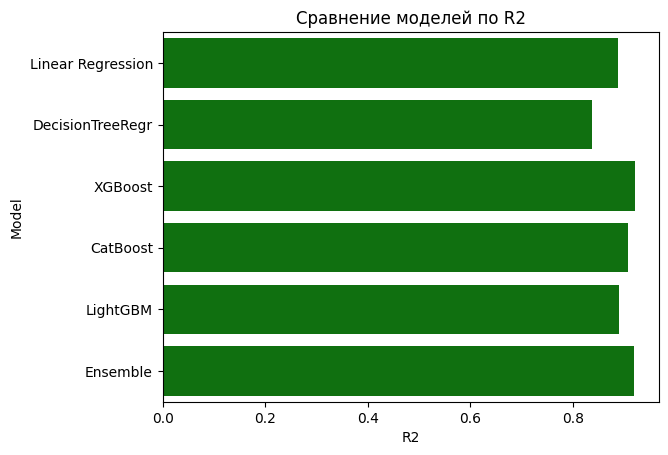

In [58]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'DecisionTreeRegr', 'XGBoost', 'CatBoost', 'LightGBM', 'Ensemble'],
    'MAE': [mae, mae_tree, mae_xgb, mae_catboost, mae_lightgbm, mae_ensemble],
    'MSE': [mse, mse_tree, mse_xgb, mse_catboost, mse_lightgbm, mse_ensemble],
    'R2': [r2, r2_tree, r2_xgb, r2_catboost, r2_lightgbm, r2_ensemble]
})

sns.barplot(x='R2', y='Model', data=results, color='green')
plt.title('Сравнение моделей по R2')
plt.show()


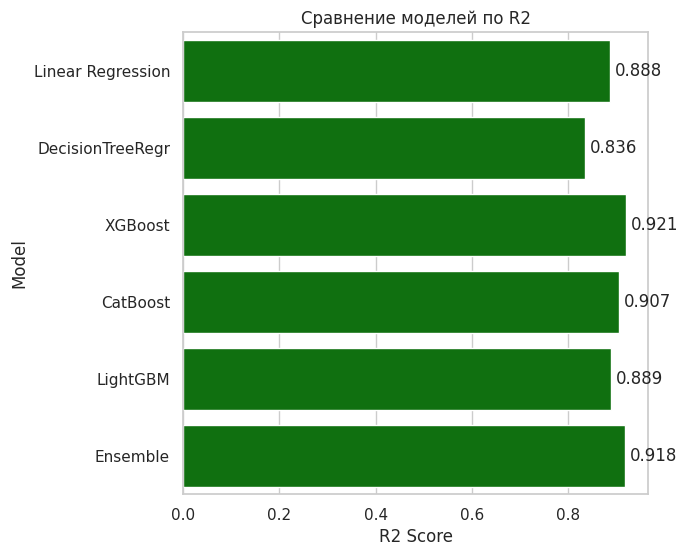

In [59]:
# Создание графика
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
ax = sns.barplot(x='R2', y='Model', data=results, color='green')

# Добавление подписей
for index, row in results.iterrows():
    plt.text(row['R2'] + 0.01, index, f"{row['R2']:.3f}", va='center')

plt.title('Сравнение моделей по R2')
plt.xlabel('R2 Score')
plt.ylabel('Model')
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


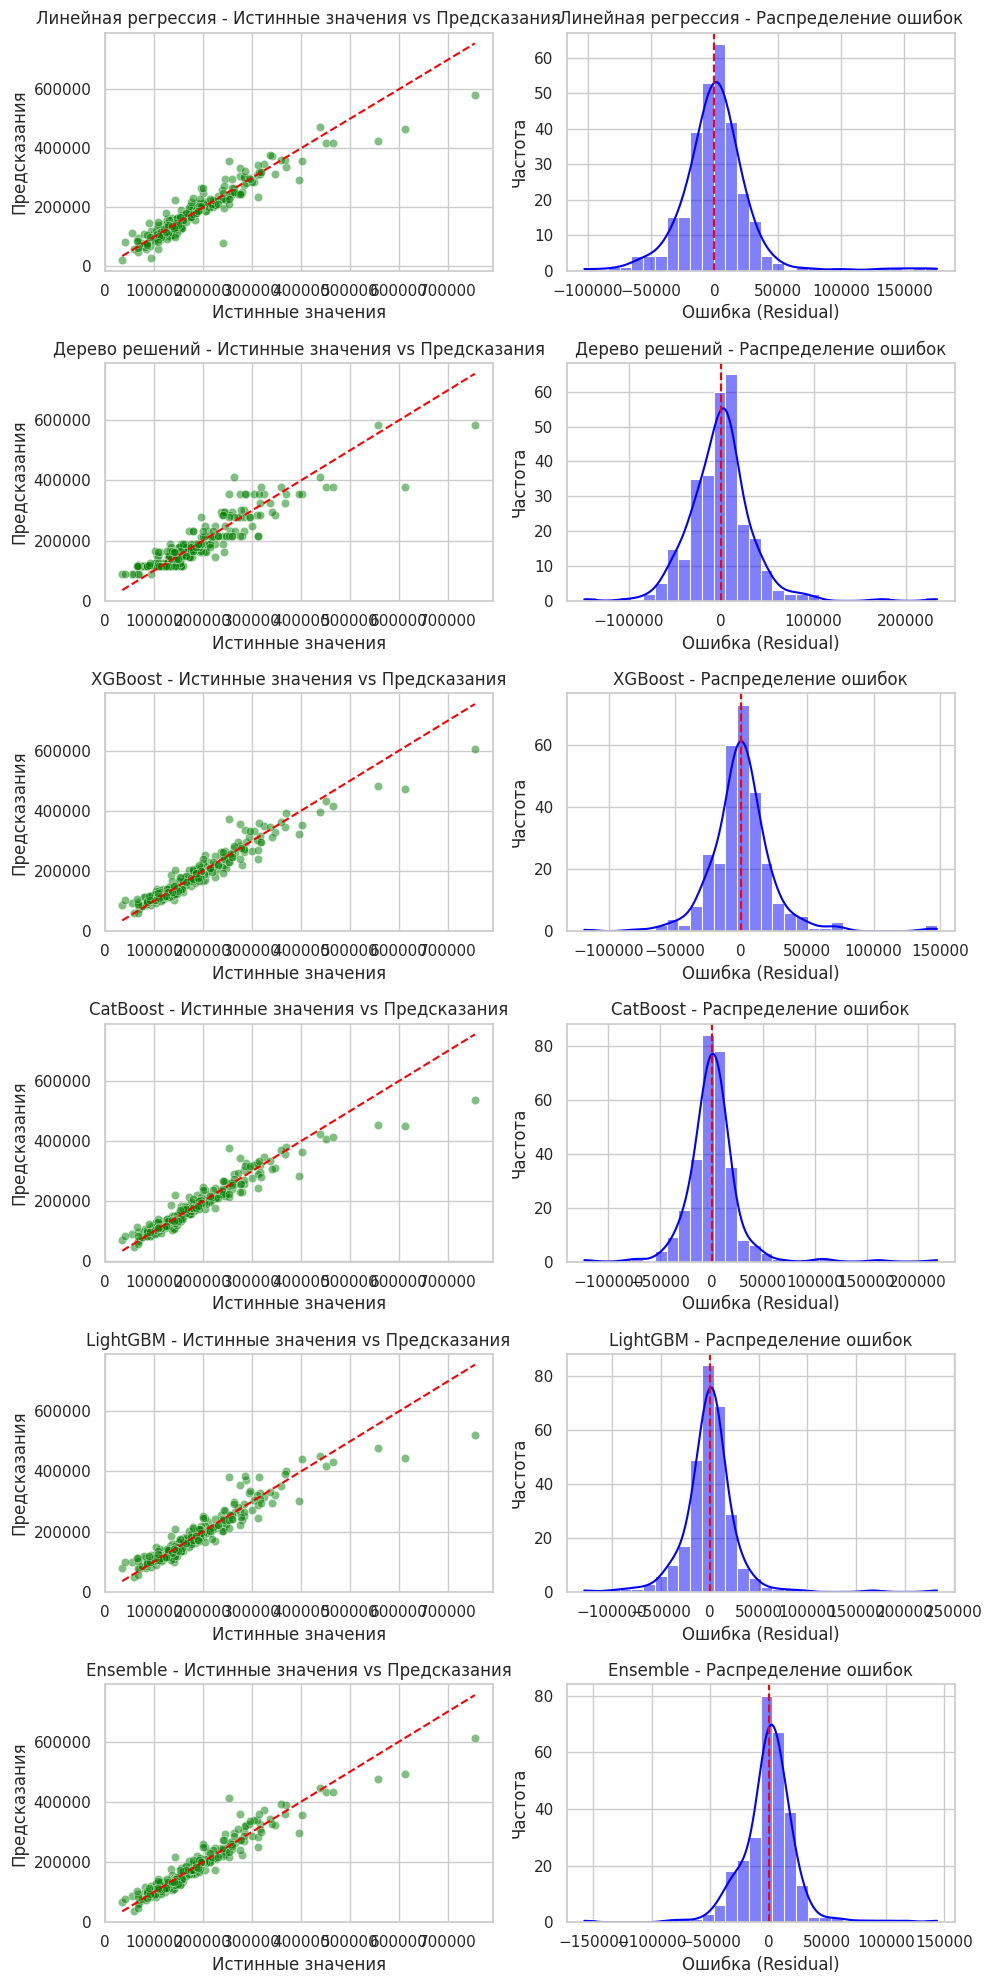

In [60]:
# Словарь с моделями и их предсказаниями
models = {
    'Линейная регрессия': y_pred_lr,
    'Дерево решений': y_pred_tree,
    'XGBoost': y_pred_xgb,
    'CatBoost': y_pred_catboost,
    'LightGBM': y_pred_lightgbm,
    'Ensemble': ensemble_pred_stack
}

# Размер холста для графиков
plt.figure(figsize=(10, 20))

# Построение графиков
for i, (model_name, predictions) in enumerate(models.items()):
    # True vs Predictions
    plt.subplot(len(models), 2, 2*i + 1)
    sns.scatterplot(x=y_test, y=predictions, alpha=0.5, color='green')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.title(f'{model_name} - Истинные значения vs Предсказания')
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказания')

    # Residuals (Ошибки)
    plt.subplot(len(models), 2, 2*i + 2)
    residuals = y_test - predictions
    sns.histplot(residuals, kde=True, color='blue', bins=30)
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f'{model_name} - Распределение ошибок')
    plt.xlabel('Ошибка (Residual)')
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

In [61]:
print(results)

               Model           MAE           MSE        R2
0  Linear Regression  18404.111959  8.568543e+08  0.888290
1   DecisionTreeRegr  23993.506849  1.254539e+09  0.836443
2            XGBoost  15725.285143  6.061099e+08  0.920980
3           CatBoost  15584.785163  7.148125e+08  0.906808
4           LightGBM  17286.555492  8.496182e+08  0.889233
5           Ensemble  15694.915208  6.267927e+08  0.918283


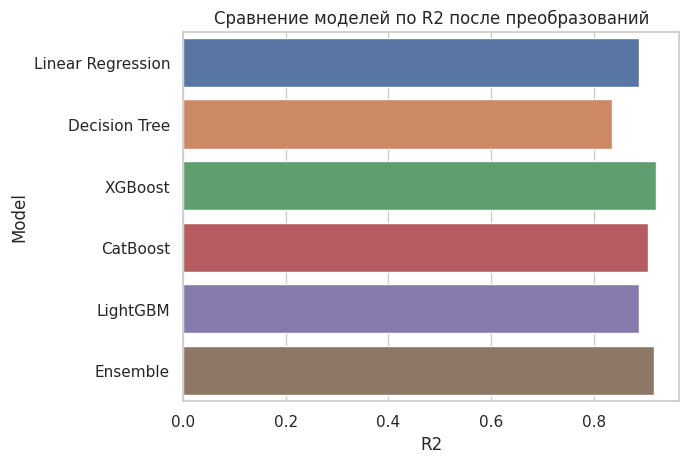

In [62]:
# Сравнение моделей
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'XGBoost', 'CatBoost', 'LightGBM', 'Ensemble'],
    'MAE': [mae, mae_tree, mae_xgb, mae_catboost, mae_lightgbm, mae_ensemble],
    'MSE': [mse, mse_tree, mse_xgb, mse_catboost, mse_lightgbm, mse_ensemble],
    'R2': [r2, r2_tree, r2_xgb, r2_catboost, r2_lightgbm, r2_ensemble]
})

sns.barplot(x='R2', y='Model', data=results)
plt.title('Сравнение моделей по R2 после преобразований')
plt.show()

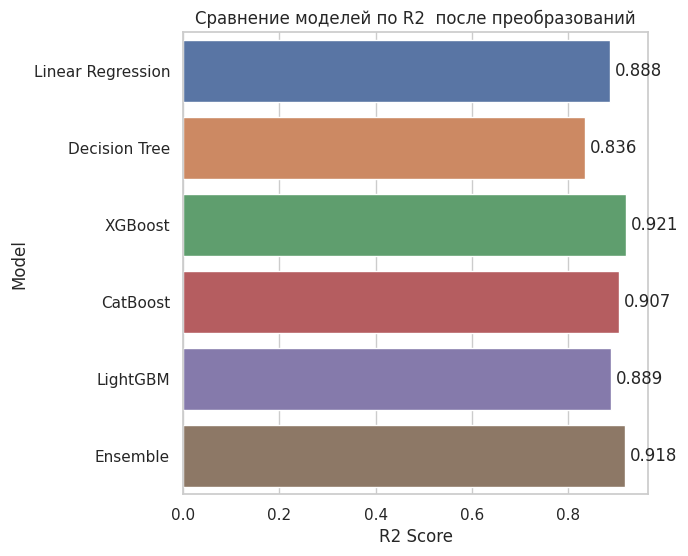

In [63]:
# Создание графика
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))
ax = sns.barplot(x='R2', y='Model', data=results)

# Добавление подписей
for index, row in results.iterrows():
    plt.text(row['R2'] + 0.01, index, f"{row['R2']:.3f}", va='center')

plt.title('Сравнение моделей по R2  после преобразований')
plt.xlabel('R2 Score')
plt.ylabel('Model')
plt.show()

In [64]:
# Вывод результатов
print(f"Время обучения XGBoost: {xgb_time:.2f} секунд")
print(f"Время обучения ансамбля (XGBoost + LightGBM + CatBoost): {ensemble_time:.2f} секунд")

Время обучения XGBoost: 0.31 секунд
Время обучения ансамбля (XGBoost + LightGBM + CatBoost): 3.80 секунд


In [65]:
train_data.LandContour[50:500]

50     Lvl
51     Lvl
52     Bnk
53     Low
54     Bnk
      ... 
495    Lvl
496    Lvl
497    Lvl
498    Lvl
499    Lvl
Name: LandContour, Length: 450, dtype: object

In [66]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_lr = rmsle(y_test, y_pred_lr)
rmsle_tree = rmsle(y_test, y_pred_tree)
rmsle_xgb = rmsle(y_test, y_pred_xgb)
rmsle_catboost = rmsle(y_test, y_pred_catboost)
rmsle_lightgbm = rmsle(y_test, y_pred_lightgbm)
rmsle_ensemble = rmsle(y_test, ensemble_pred_stack)

print(f"RMSLE for Linear Regression: {rmsle_lr}")
print(f"RMSLE for Decision Tree: {rmsle_tree}")
print(f"RMSLE for XGBoost: {rmsle_xgb}")
print(f"RMSLE for CatBoost: {rmsle_catboost}")
print(f"RMSLE for LightGBM: {rmsle_lightgbm}")
print(f"RMSLE for Ensemble: {rmsle_ensemble}")

RMSLE for Linear Regression: 0.17805483574088116
RMSLE for Decision Tree: 0.19094561157475845
RMSLE for XGBoost: 0.14098820157095265
RMSLE for CatBoost: 0.1311247086775386
RMSLE for LightGBM: 0.14959113006078853
RMSLE for Ensemble: 0.133869061298244


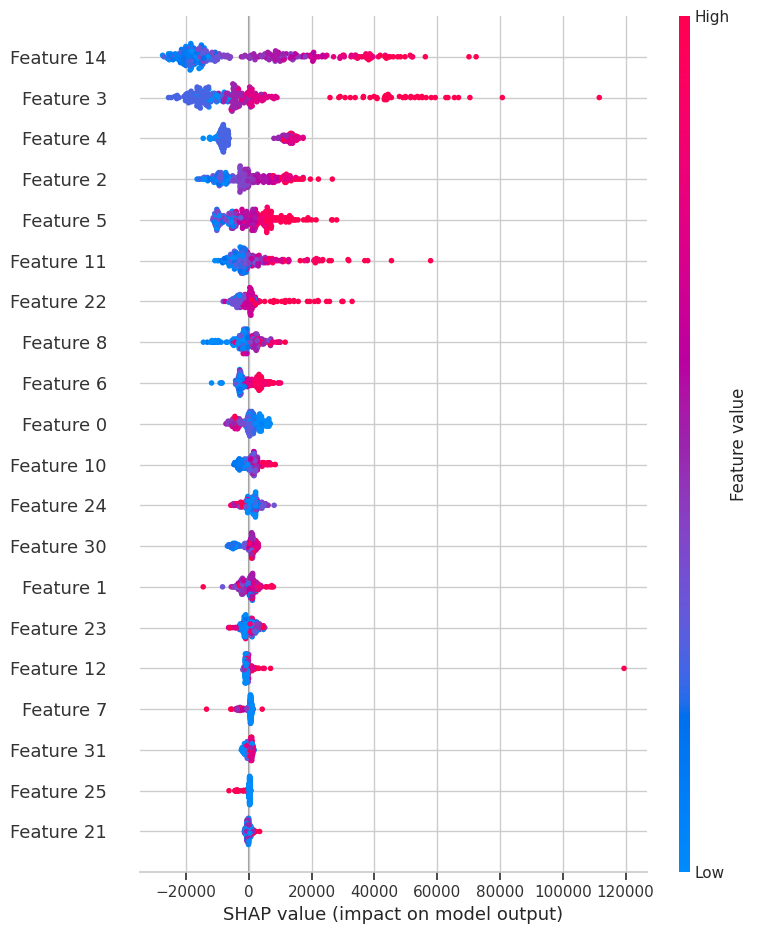

In [67]:
# Преобразование разреженной матрицы в плотный массив
X_train_dense = X_train.toarray()  # Преобразуем обучающую выборку
X_test_dense = X_test.toarray()  # Преобразуем тестовую выборку

# SHAP для XGBoost
explainer_xgb = shap.Explainer(xgb, X_train_dense)  # Объяснитель для XGBoost
shap_values_xgb = explainer_xgb(X_test_dense)  # Получаем SHAP-значения для теста

# Визуализация важности признаков для XGBoost
shap.summary_plot(shap_values_xgb, X_test_dense)

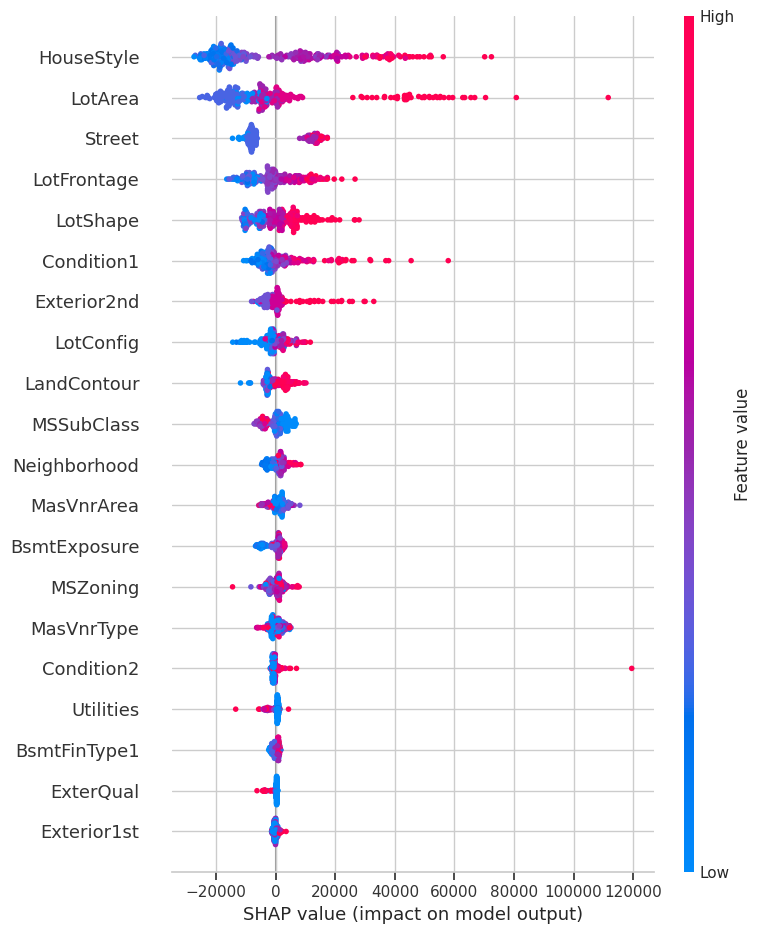

In [68]:
# Преобразуем X_train и X_test в плотные массивы
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Объяснение модели с помощью SHAP
explainer = shap.Explainer(xgb, X_train_dense)
shap_values = explainer(X_test_dense)

# Визуализация значений SHAP
# График важности признаков
shap.summary_plot(shap_values, X_test_dense, feature_names=X.columns)

In [ ]:
# Для соревнования на каггле

In [86]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [96]:
columns_to_drop = ['GarageYrBlt', 'TotRmsAbvGrd', 'GarageArea', 'TotalBsmtSF']
test_data = test_data.drop(columns=columns_to_drop, errors='ignore')

numerical_features_test = [col for col in numerical_features if col in test_data.columns]
num_imputer = SimpleImputer(strategy='median')
num_imputer.fit(train_data[numerical_features_test])
test_data[numerical_features_test] = num_imputer.transform(test_data[numerical_features_test])


categorical_features_test = [col for col in categorical_features if col in test_data.columns]
if len(categorical_features_test) > 0:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    cat_imputer.fit(train_data[categorical_features_test])
    test_data[categorical_features_test] = cat_imputer.transform(test_data[categorical_features_test])

In [97]:
X_test_kaggle = preprocessor.transform(test_data)
y_pred_kaggle = xgb.predict(X_test_kaggle)

In [100]:
submission = pd.DataFrame({
    'Id': test_data['Id'],
    'SalePrice': y_pred_kaggle
})
submission['Id'] = submission['Id'].astype(int)
submission.to_csv('submission_houses.csv', index=False)